### References

**Book:**
- Deep Learning with Python, Second Edition
  - Book by François Chollet
  - François Chollet is a French software engineer and artificial intelligence researcher currently working at Google. Chollet is the creator of the Keras deep-learning library, released in 2015, and a main contributor to the TensorFlow machine learning framework.


### What went wrong in ANN and Convnets?

We can try out 1D convnets for the same timeseries modeling that we performed with ANNs

As it turns out, 1D convnet model performs even worse than the densely connected one, only achieving a validation MAE of about 2.9 degrees, far from the common-sense baseline.

**What went wrong here?**
1. First, weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
2. Second, order in our data matters—a lot. The recent past is far more informa-
tive for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information.

Neither the fully connected approach nor the convolutional approach did well, but that doesn’t mean machine learning isn’t applicable to this problem. 

The densely connected approach first flattened the timeseries, which removed the notion of time from the input data. 

The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information. 

Let’s instead look at the data as what it is: a sequence, where causality and order matter.

### Code

In [2]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Inspecting the data of the Jena weather dataset

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

# Getting individual lines
lines = data.split("\n")

# First line contain headers
header = lines[0].split(",")

# Second to end lines are data
lines = lines[1:]

print(header)
print(len(header))

print("\n")

print("Number of samples",len(lines))

print("\n")

print("First sample:\n", lines[0])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15


Number of samples 420451


First sample:
 01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30


In [4]:
# Parsing the data - Converting into numpy arrays

# Target
temperature = np.zeros((len(lines),))
# Features
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    # Excluding date-time
    values = [float(x) for x in line.split(",")[1:]]
    
    # We store column 1 (second column) in the “temperature” array
    temperature[i] = values[1]

    # We store all columns (including the temperature) in the “raw_data” array
    raw_data[i, :] = values[:]

In [5]:
# Computing the number of samples we’ll use for each data split

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [6]:
# Normalizing the data

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [7]:
# Instantiating datasets for training, validation, and testing

sampling_rate = 6

# Observations will go back 5 days (120 hours)
sequence_length = 120

# Target for a sequence will be the temperature 24 hours after the end of the sequence
delay = sampling_rate * (sequence_length + 24 - 1)

batch_size = 256

# Training dataset
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

# Validation Dataset
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

# Test dataset
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [8]:
# Inspecting the output of one of our datasets

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [11]:
# A simple LSTM-based model

# Architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

# Model
model = keras.Model(inputs, outputs)

# Callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
                                    ]

# Compilation
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Training
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)



Epoch 1/10


819/819 [==============================] - 98s 115ms/step - loss: 37.9645 - mae: 4.4890 - val_loss: 12.1719 - val_mae: 2.6777
Epoch 2/10
819/819 [==============================] - 100s 122ms/step - loss: 10.9933 - mae: 2.5796 - val_loss: 9.8924 - val_mae: 2.4517
Epoch 3/10
819/819 [==============================] - 99s 120ms/step - loss: 9.7999 - mae: 2.4405 - val_loss: 10.0201 - val_mae: 2.4600
Epoch 4/10
819/819 [==============================] - 100s 122ms/step - loss: 9.4624 - mae: 2.3929 - val_loss: 10.0440 - val_mae: 2.4547
Epoch 5/10
819/819 [==============================] - 99s 121ms/step - loss: 9.2635 - mae: 2.3645 - val_loss: 9.8252 - val_mae: 2.4330
Epoch 6/10
819/819 [==============================] - 99s 121ms/step - loss: 9.0533 - mae: 2.3338 - val_loss: 10.0581 - val_mae: 2.4433
Epoch 7/10
819/819 [==============================] - 101s 123ms/step - loss: 8.7986 - mae: 2.3010 - val_loss: 9.8839 - val_mae: 2.4342
Epoch 8/10
819/819 [======================

In [12]:
# Loading the best model
model = keras.models.load_model("jena_lstm.keras")

In [13]:
# Checking the performance on test data
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 25s 59ms/step - loss: 10.6537 - mae: 2.5616
Test MAE: 2.56


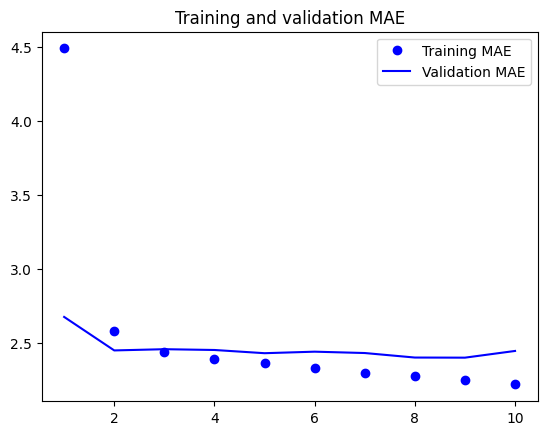

In [14]:
# Plotting the results
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

plt.show()

We achieve a validation MAE as low as 2.44 degrees and a test MAE of 2.56 degrees. 

The LSTM-based model can finally beat the common-sense baseline (albeit just by a bit, for now), demonstrating the value of machine learning on this task.

**Understanding RNNs**

A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that they have no memory. 

Each input shown to them is processed independently, with no state kept between inputs. With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. 

For instance, this is what we did in the densely connected network example: we flattened our five days of data into a single large vector and processed it in one go. 

Such networks are called feedforward networks.

The state of the RNN is reset between processing two different, independent sequences (such as two samples in a
batch), so you still consider one sequence to be a single data point: a single input to the network. 

What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements.

In [ ]:
# Pseudocode RNN

"""
state_t = 0

for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t

"""

# More-detailed pseudocode for the RNN

"""
state_t = 0

for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t
"""

In [18]:
# NumPy implementation of a simple RNN

timesteps = 5
input_features = 4
output_features = 8

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []

for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)

print(final_output_sequence)

[[0.89229791 0.82789039 0.78321816 0.94441689 0.73679983 0.48278071
  0.93578303 0.86801708]
 [0.99938624 0.99988908 0.99930204 0.99884121 0.99952253 0.99983915
  0.99990404 0.99991911]
 [0.99980981 0.99997404 0.99986747 0.99927071 0.99991647 0.99997181
  0.99993856 0.99994718]
 [0.99977294 0.99997438 0.99983583 0.99967691 0.99984014 0.99995716
  0.99998311 0.99995027]
 [0.99992919 0.99999378 0.99997558 0.99995648 0.99987515 0.99998642
  0.9999949  0.99998947]]


In [ ]:
# An RNN layer that can process sequences of any length

num_features = 14

# When specifying the shape argum ent of the initial Input(), note that you can set the timesteps entry to None, which enables your network to process sequences of arbitrary length. 
inputs = keras.Input(shape=(None, num_features))

outputs = layers.SimpleRNN(16)(inputs)

This is especially useful if your model is meant to process sequences of variable length.

However, if all of your sequences have the same length, I recommend specifying a complete input shape, since it enables model.

summary() to display output length information, which is always nice, and it can unlock some performance optimization.

All recurrent layers in Keras (SimpleRNN, LSTM, and GRU) can be run in two different modes: they can return either full sequences of successive outputs for each timestep (a rank-3 tensor of shape (batch_size, timesteps, output_features)) or return only the last output for each input sequence (a rank-2 tensor of shape (batch_
size, output_features)). 

These two modes are controlled by the `return_sequences` constructor argument. 

In [19]:
# An RNN layer that returns only its last output step

num_features = 14
steps = 120

inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)

print(outputs.shape)

(None, 16)


In [20]:
# An RNN layer that returns its full output sequence

num_features = 14
steps = 120

inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)

print(outputs.shape)

(None, 120, 16)


It’s sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all of the intermediate layers to return a full sequence of outputs.

In [21]:
# Stacking RNN layers

num_features = 14
steps = 120

inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

print(outputs.shape)

(None, 16)


**Using recurrent dropout to fight overfitting**

It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization.

The same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep.

What’s more, in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask).

Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

In [ ]:
# Training and evaluating a dropout-regularized LSTM 
# (Per epoch takes 3.5 minutes)

# Architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)

# To regularize the Dense layer, we also add a Dropout layer after the LSTM
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1)(x)

# Model
model = keras.Model(inputs, outputs)

# Callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
                                    ]

# Compilation
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Training
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

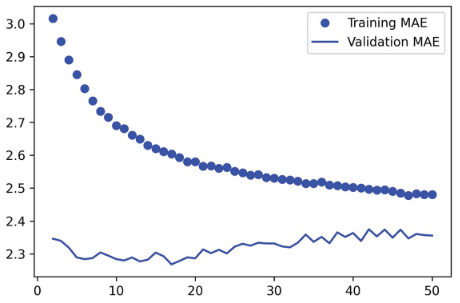

We’re no longer overfitting during the first 20 epochs. 

We achieve a validation MAE as low as 2.27 degrees (7% improvement over the no-learning baseline) and a test MAE of 2.45 degrees (6.5% improvement over the baseline). Not too bad.

**RNN runtime performance**
As a way to speed up your RNN layer when you can’t use cuDNN, you can try unrolling it. 

Unrolling a for loop consists of removing the loop and simply inlining its content N times. 

In the case of the for loop of an RNN, unrolling can help TensorFlow optimize the underlying computation graph. 

However, it will also considerably increase the memory consumption of your RNN—as such, it’s only viable for relatively small sequences (around 100 steps or fewer). 

Also, note that you can only do this if the number of timesteps in the data is known in advance by the model (that is to say, if you pass a shape without any None entries to your initial Input())

```
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)
```

**Stacking recurrent layers**

Because we’re no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity and expressive power of the network.

Recurrent layer stacking is a classic way to build more-powerful recurrent networks: for instance, not too long ago the Google Translate algorithm was powered by a stack of seven large LSTM layers—that’s huge.

In the following example, we’ll try a stack of two dropout-regularized recurrent layers. 

For a change, we’ll use Gated Recurrent Unit (GRU) layers instead of LSTM. 

GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture.

In [ ]:
# Training and evaluating a dropout-regularized, stacked GRU model (Per epoch takes 5 minutes)

# Architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

# Model
model = keras.Model(inputs, outputs)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
                                    ]

# Compilation
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Training
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
# Loading the best model
model = keras.models.load_model("jena_stacked_gru_dropout.keras")

# Evaluating on the test dataset
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

We achieve a test MAE of 2.39 degrees (an 8.8% improvement over the baseline). 

You can see that the added layer does improve the results a bit, though not dramatically. 

You may be seeing diminishing returns from increasing network capacity at this point.

**Using bidirectional RNNs**

A bidirectional RNN exploits the order sensitivity of RNNs: it uses two regular RNNs, such as the GRU and LSTM layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merges their representations. 

By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

**Antichronological order RNN**

For antichronological order RNN all you need to do is write a variant of the data generator where the input sequences are reverted along the time dimension (replace the last line with yield samples[:, ::-1, :], targets).

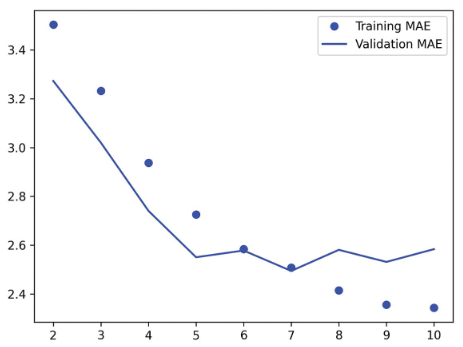

The reversed-order LSTM strongly underperforms even the common-sense baseline, indicating that in this case, chronological processing is important to the success of the approach. 

This makes perfect sense: the underlying LSTM layer will typically be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points for the problem (that’s what makes the common-sense baseline fairly strong). 

Thus the chronological version of the layer is bound to outperform the reversed-order version.

In [ ]:
# Training and evaluating a bidirectional LSTM

# Architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)

# Model
model = keras.Model(inputs, outputs)

# Compilation
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Training
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

You’ll find that it doesn’t perform as well as the plain LSTM layer. 

It’s easy to understand why: all the predictive capacity must come from the chronological half of the
network, because the antichronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past, in this case). 

At the same time, the presence of the antichronological half doubles the network’s capacity and causes it to start overfitting much earlier.